In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import chess
import chess.pgn

from torch.utils.data import Dataset, DataLoader, IterableDataset

from time import time
import tqdm

HEADERS = ("result", "whiteElo", "blackElo", "timeControl", "sideToPlay", "bitmaps", "movePlayed")
TRAINING_SET_SIZE = 50_000
BATCH_SIZE = 64

In [2]:
def extract_fens_from_pgn(pgn_file, label_from="result"):
    positions = []
    with open(pgn_file, "r", encoding="utf-8") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            result = game.headers.get("Result")

            # Label based on game outcome
            if result == "1-0":
                label = 1.0
            elif result == "0-1":
                label = -1.0
            else:
                label = 0.0

            # Step through moves
            for move in game.mainline_moves():
                board.push(move)
                fen = board.fen()
                positions.append((fen, label))  # ← You can also call Stockfish here if you want

    return positions


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class PositionEvaluatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))  # Output between -1 and 1
    

class ChessBotNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 13 channels: 12 pieces + side to play (tensor[true's|false's])
        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64) # In case of pawn promotion, we assume it promotes to a queen

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Idea:
##   One model that answers "best piece to move in this position"
##   Then another model that answers "best square to move piece X to"

In [4]:
piece_to_idx = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def board_to_tensor(board):
    tensor = np.zeros((12, 8, 8), dtype=np.uint8)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            idx = piece_to_idx[piece.symbol()]
            row = 7 - square // 8
            col = square % 8
            tensor[idx, row, col] = 1
    return tensor

In [5]:
import ast
import csv
from io import StringIO
import random
from typing import Literal
import pandas as pd

# class ChessEvalDataset(Dataset):
class ChessEvalDataset(Dataset):
    def __init__(self, file: str, model: Literal["pieces", "moves"] = "pieces"):
        self.file = file
        self.model = model

        self.__fetch_from_file(0)

    def __len__(self):
        return TRAINING_SET_SIZE
    
    def __fetch_from_file(self, idx: int):
        self.dataset = pd.read_csv(
            self.file,
            # skiprows=idx,
            nrows=TRAINING_SET_SIZE,
            names=HEADERS
        )
        return;
    
        bitmaps = []
        bitmaps = self.dataset["bitmaps"]  
        for bitmap_str in bitmaps:
            try:
                # Convert string to list
                bitmap = ast.literal_eval(bitmap_str)
                # Convert to NumPy array
                bitmaps.append(bitmap)
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing bitmap: {e}")
                print(f"Problematic string: {bitmap_str[:100]}...")  
                bitmaps.append(np.zeros((13, 8, 8))) 

        bitmaps = np.array(bitmaps)

            

    
        # Convert string to list
        # Convert to NumPy array
        bitmaps = np.array(
            dataset["bitmaps"]
              .apply(ast.literal_eval)
              .tolist()
        )

        side_to_play_bool = dataset["sideToPlay"].to_numpy()
        side_channels = []
        for play_white in side_to_play_bool:
            side_channel = np.ones((1, 8, 8)) if play_white else np.zeros((1, 8, 8))
            side_channels.append(side_channel)
        side_channels = np.array(side_channels)
        bitmaps = np.concatenate((bitmaps, side_channels), axis=1)

        # Convert to tensor
        X = torch.tensor(bitmaps, dtype=torch.float32)[0]

        # From "a2b5", extract a2 if piece or b5 if move
        if self.model == "pieces":
            y = np.array(dataset["movePlayed"].astype(str).str[:2])[0]
        elif self.model == "moves":
            y = np.array(dataset["movePlayed"].astype(str).str[2:])[0]
        
        return X, y
    
    def __uciMoveToSquare(self, move: str):
        return (ord(move[0]) - ord('a')) + (int(move[1]) - 1) * 8

    def __getitem__(self, idx):
        # aux function
        # position, move = self.__fetch_from_file(idx)
        row = self.dataset.iloc[idx]
        bitmaps = ast.literal_eval(row["bitmaps"])

        if self.model == "pieces":
            y = row["movePlayed"][:2]
        elif self.model == "moves":
            y = row["movePlayed"][2:]

        play_white = row["sideToPlay"]
        side_channel = np.ones((1, 8, 8)) if play_white else np.zeros((1, 8, 8))
        bitmaps = np.concatenate((bitmaps, side_channel), axis=0)

        return torch.tensor(bitmaps).float(), torch.tensor(self.__uciMoveToSquare(y)).long()
    

    def parse_line(self, line: str):
        parts = next(
            csv.DictReader(StringIO(line), quoting=csv.QUOTE_MINIMAL, fieldnames=HEADERS)
        )
        
        entry = {
            "bitmaps": ast.literal_eval(parts["bitmaps"]),
            "sideToPlay": parts["sideToPlay"] == "True",
            "movePlayed": parts["movePlayed"]
        }

        bitmaps = np.array(entry["bitmaps"])
        side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] else np.zeros((1, 8, 8))

        bitmaps = np.concatenate((bitmaps, side_channel))
        X = torch.tensor(bitmaps, dtype=torch.float32)

        move = entry["movePlayed"]
        if self.model == "pieces":
            label = move[:2]
        else:
            label = move[2:]
        y = np.zeros(shape=(64, 1))
        y[self.__uciMoveToSquare(label)] = 1
        y = torch.tensor(y).long()


        return X, y
    
    # def __iter__(self):
    #     chosen_indices = set(sorted(random.sample(range(0, TRAINING_SET_SIZE), BATCH_SIZE)))
    #     with open(self.file, "r") as f:
    #         for i, line in enumerate(f):
    #             if i in chosen_indices:
    #                 yield self.parse_line(line)

In [6]:
# DATASET_PATH = '../dataset/processed/results_skip_initial.csv'
# NUM_EPOCHS = 100

# TRAINING_MODE = "pieces" # "pieces" or "moves"
# MODEL_WEIGHTS_OUTPUT_PATH = "pieces_model.pth"
# test = ChessEvalDataset(file = DATASET_PATH, model=TRAINING_MODE)
# loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ChessBotNetwork().to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = torch.nn.CrossEntropyLoss()

# print(torch.cuda.is_available())
# print("Using device: ", device)
# for epoch in range(NUM_EPOCHS):
#     model.train()
#     t0 = time()
#     for board_tensor_batch, target_eval_batch in tqdm.tqdm(loader):
#         # Load data to GPU
#         board_tensor_batch, target_eval_batch = board_tensor_batch.to(device), target_eval_batch.to(device)
#         # predict
#         pred = model(board_tensor_batch)

#         optimizer.zero_grad()
        
#         # Calculate loss
#         loss = loss_fn(pred, target_eval_batch)
#         loss.backward()

#         optimizer.step()
#     tf = time()
#     print(f"Epoch {epoch}, Loss: {loss.item():.4f} | Time: {tf-t0}")


# # Save the trained model
# torch.save(model.state_dict(), MODEL_WEIGHTS_OUTPUT_PATH)

In [82]:
import csv
from io import StringIO
import pandas as pd
import numpy as np
import ast
# torch.save(model.state_dict(), "pieces_model_test.pth")
test = pd.read_csv(
    '../dataset/processed/results_skip_initial.csv', 
    nrows = 20, 
    names = HEADERS,
)
entry = test.iloc[0]
bitmaps = np.array(ast.literal_eval(entry["bitmaps"]))
side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] == "True" else np.zeros((1, 8, 8))

bitmaps = np.concatenate((bitmaps, side_channel), axis=0)
X = bitmaps
played_move = entry["movePlayed"]

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = ChessBotNetwork().to(device)
trained_model.load_state_dict(torch.load("pieces_model_test.pth"))
trained_model.eval()  # Set model to evaluation mode

def predict_move(bitmaps):
    X_tensor = torch.tensor(bitmaps, dtype=torch.float32).cuda().to(device)
    
    with torch.no_grad():
        logits = trained_model(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    
    return probabilities

In [77]:
# import matplotlib.pyplot as plt
# import chess

# def plot_board(bitmaps, move_probs=None):
#     board = np.zeros((8,8,3))
#     colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

#     fig, ax = plt.subplots(figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             color = colors[(i + j) % 2]
#             rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
#             ax.add_patch(rect)
#             piece_symbols = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

#     for idx, symbol in enumerate(piece_symbols):
#         channel = bitmaps[idx]
#         for i in range(8):
#             for j in range(8):
#                 if channel[i, j] == 1:
#                     ax.text(j + 0.5, 7-i + 0.5, symbol, fontsize=24, ha='center', va='center')

#     if move_probs is not None:
#         for i in range(8):
#             for j in range(8):
#                 prob = move_probs[i, j]
#                 if prob > 0.05: 
#                     ax.text(j + 0.5, 7-i + 0.8, f"{prob:.2f}", fontsize=8, color="red", ha='center')

#     ax.set_xlim(0, 8)
#     ax.set_ylim(0, 8)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Mapping of piece letters to unicode chess symbols
PIECE_UNICODE = {
    'P': '♙', 'N': '♘', 'B': '♗', 'R': '♖', 'Q': '♕', 'K': '♔',
    'p': '♟︎', 'n': '♞', 'b': '♝', 'r': '♜', 'q': '♛', 'k': '♚'
}

def plot_board(bitmaps, move_probs=None):
    board = np.zeros((8, 8, 3))
    colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw squares
    for i in range(8):
        for j in range(8):
            color = colors[(i + j) % 2]
            rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
            ax.add_patch(rect)

    # Draw pieces
    piece_symbols = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
    for idx, symbol in enumerate(piece_symbols):
        channel = bitmaps[idx]
        for i in range(8):
            for j in range(8):
                if channel[i, j] == 1:
                    piece_unicode = PIECE_UNICODE[symbol]
                    ax.text(j + 0.5, i + 0.5, piece_unicode, fontsize=48, ha='center', va='center')

    # Draw move probabilities
    if move_probs is not None:
        for i in range(8):
            for j in range(8):
                prob = move_probs[i, j]
                if prob > 0:  # Show only significant probs
                    ax.text(j + 0.5, i+ 0.1, f"{prob:.2f}", fontsize=8, color="red", ha='center')
                    # ax.text(j + 0.5, i + 0.8, f"{i*8 + j}", fontsize=8, color="red", ha='center')

    # Add a-h and 1-8 labels
    # files = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
    for i in range(8):
        # Bottom labels
        ax.text(i + 0.5, -0.3, files[i], ha='center', va='center', fontsize=14)
        # Left side labels
        ax.text(-0.3, i + 0.5, ranks[7-i], ha='center', va='center', fontsize=14)

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


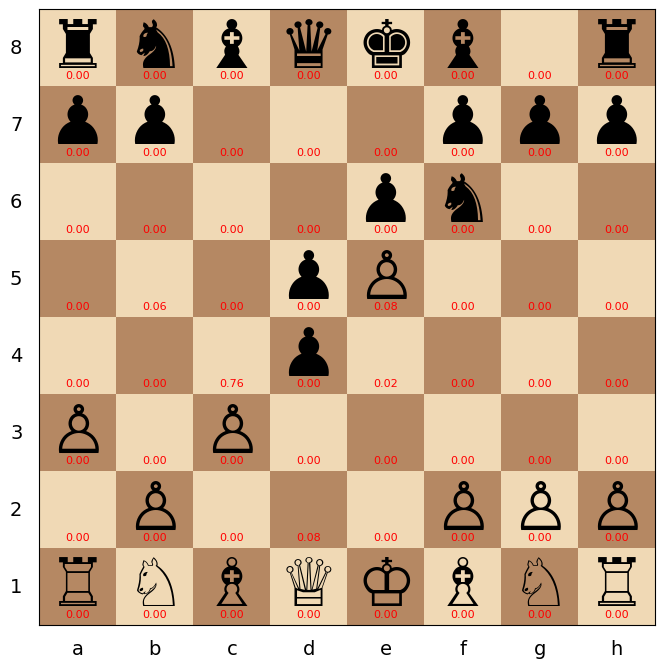

array([4.6589840e-03, 8.3108813e-02, 7.6623895e-04, 7.5574476e-01,
       7.6813303e-02, 2.0228499e-06, 5.6386908e-04, 8.0368619e-07],
      dtype=float32)

In [78]:
y = predict_move(bitmaps)  # model output
y2 = np.reshape(y, (8, 8)) # reshape to 8x8
plot_board(bitmaps, move_probs=y2)
np.max(y2, axis=1)

In [11]:
# board = chess.Board()

# while not board.is_game_over():
#     print(board)
#     user_move = input("Your move (e.g., e2e4): ")
#     try:
#         board.push_uci(user_move)
#     except Exception as e:
#         print("Invalid move. Try again.")
#         continue

#     # Convert board to bitmap
#     bitmaps = board_to_tensor(board)
#     side_channel = np.ones((1, 8, 8)) if board.turn == chess.WHITE else np.zeros((1, 8, 8))
#     input_tensor = np.concatenate((bitmaps, side_channel), axis=0)

#     # Model predicts best move
#     probs = predict_move(input_tensor)
#     best_square_idx = np.argmax(probs, keepdims=True)

#     from_square = best_square_idx
#     # Here you can pick any legal move from that square (some logic needed)
#     # For now, let's print it
#     print(f"Model suggests moving from square index {from_square}")
#     plot_board(input_tensor, move_probs=np.reshape(probs, (8,8)))
